# 2.1 Station meta data handling in Obspy

This chapter will show multiple steps of station meta data handling in *Obspy* as
* StationXML loading
* Station extraction
* Station manipulation
* Control of the instrument response
* Instrument response removal of recorded waveforms.

## Contents
* [Loading and first display](#sec1)
* [Manually add a station](#sec2)
* [Saving](#sec3)
* [Instrument response and its removal](#sec4)
* [Summary](#sum)


## Loading and first display  <a class="anchor" id="sec1"></a>

*Obspy* uses inventories to store station meta data in. Loading is done via `read_inventory`.

In [2]:
# import loading function
from obspy import read_inventory

# Stations are loaded into an inventory
inv = read_inventory('data/stations.xml')

The inventory allows for some fast inspection of the station meta data e.g. using the built-in map `plot`:

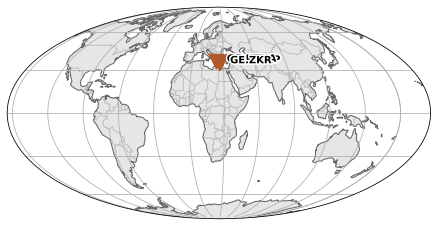

In [3]:
# Plot the location of the stations.
inv.plot();

Furthermore you are also able to access the station meta data. Within the inventory there is a strict hierachy:
1. Each inventory contains network(s)
1. Each network contains station(s)
1. Each station contains channel(s)
.
.
.
<figure>
    <img src="https://docs.obspy.org/_images/Inventory.png">
    <caption>Fig.: Obspy inventory hierachy (image from the obspy documentation)</caption>
</figure>

Following the shown hierachy we can now iterate through each station within each loaded network and display some station parameters e.g. network and station code together with the station location:

In [4]:
# Extract station information
for net in inv.networks:
    for s in net:
        print('{}.{:<4}: lat [deg] {:.4f}, lon [deg] {:.4f}'.format(net.code, s.code, s.latitude, s.longitude))
        
# OR simply
print(inv)

GE.KARP: lat [deg] 35.5471, lon [deg] 27.1611
GE.KTHA: lat [deg] 36.2566, lon [deg] 23.0621
GE.ZKR : lat [deg] 35.1147, lon [deg] 26.2169
Inventory created at 2020-11-09T13:45:37.274930Z
	Sending institution: merged from different sources
	Contains:
		Networks (1):
			GE
		Stations (3):
			GE.KARP (NOA/RUB/GEOFON Station Karpathos,Greece)
			GE.KTHA (NOA/GEOFON Station Kythira, Greece)
			GE.ZKR (NOA/GEOFON Station Zakros, Crete)
		Channels (9):
			GE.KARP..HHZ, GE.KARP..HHN, GE.KARP..HHE, GE.KTHA..HHZ, 
			GE.KTHA..HHN, GE.KTHA..HHE, GE.ZKR..HHZ, GE.ZKR..HHN, GE.ZKR..HHE


## Manually add a station  <a class="anchor" id="sec2"></a>

Of course it is also possible to add stations manually, e.g. from your own campaign. So let's assume the hypothetical station `GE.RHD` installed on Rhodes (latitude: 36.415597 deg, longitude: 28.193360, elevation: 50 m). It has only a vertical component. We want to add this station to our inventory into the network `GE`.

First we need to import *Obspy*s `Station` and `Channel` class

In [5]:
from obspy.core.inventory import Station, Channel

In the next step we will create a Station with the given location and code:

In [6]:
station = Station(
    code='RHD',  # Station code
    # Location
    latitude=36.415597,
    longitude=28.193360, 
    elevation=50.)

Now we can add the channel information:

In [7]:
channel = Channel(
    # Channel code
    code='HHZ',
    location_code='',
    # Channel location (might be different from station location)
    latitude=36.415597,
    longitude=28.193360,
    elevation=50.,
    # Local depth
    depth=0.)

# Add channel list to the station
station.channels = [channel]

Finally the station has to be added to the inventory:

In [8]:
inv.networks[0].stations.append(station)

When now printing the inventory stats, the freshly added station `GE.RHD` appears:

In [9]:
print(inv)

Inventory created at 2020-11-09T13:45:37.274930Z
	Sending institution: merged from different sources
	Contains:
		Networks (1):
			GE
		Stations (4):
			GE.KARP (NOA/RUB/GEOFON Station Karpathos,Greece)
			GE.KTHA (NOA/GEOFON Station Kythira, Greece)
			GE.RHD ()
			GE.ZKR (NOA/GEOFON Station Zakros, Crete)
		Channels (10):
			GE.KARP..HHZ, GE.KARP..HHN, GE.KARP..HHE, GE.KTHA..HHZ, 
			GE.KTHA..HHN, GE.KTHA..HHE, GE.RHD..HHZ, GE.ZKR..HHZ, GE.ZKR..HHN, 
			GE.ZKR..HHE


## Saving <a class="anchor" id="sec3"></a>

As we have added the new station, we should also save the new inventory. The inventory allows to do so easily with the `write` method:

In [10]:
inv.write('processed_stations.xml', format='STATIONXML')

## Instrument response and its removal <a class="anchor" id="sec4"></a>

What can we use the station information for? Perhaps **restitution**, so the removal of the instrumental effects (its response) from the recorded raw waveforms. In our case let's try to remove the instrument response from the waveform record, we have seen in [1.1 Waveform handling with Obspy](1.1_waveforms_obspy.ipynb).

So, first load the waveform into a stream:

In [11]:
from obspy import read

st = read('data/data_GE.KTHA..HHZ_2020-10-30_11-30-26.mseed')

Next we will extract the instrument response for the chosen waveform from our inventory:

In [12]:
# Extract response for the given trace id (Network, station, location and channel codes)
# at the start time of the record.
response = inv.get_response(
    st[0].id,
    st[0].stats.starttime)

For quick inspection the response can be printed or even plotted:

Channel Response
	From M/S () to COUNTS ()
	Overall Sensitivity: 5.88e+08 defined at 0.020 Hz
	4 stages:
		Stage 1: PolesZerosResponseStage from M/S to V, gain: 1500
		Stage 2: CoefficientsTypeResponseStage from V to COUNTS, gain: 392000
		Stage 3: FIRResponseStage from COUNTS to COUNTS, gain: 1
		Stage 4: FIRResponseStage from COUNTS to COUNTS, gain: 1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


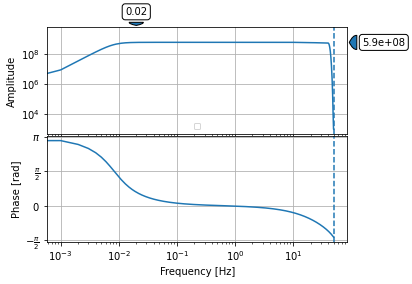

In [13]:
# Printing response information
print(response)

# Plotting the frequency depending response
response.plot(min_freq=0.001);

So, as there is a instrumental response for our chosen trace within the inventory we can now use it to obtain the ground displacements during the recorded earthquake for the trace:

In [14]:
# Choosing an individual trace (here the first) of the stream
tr = st[0].copy()

# Removing the response and extract trace in displacement
tr.remove_response(
    inventory=inv,  # Inventory to search the response in
    output='DISP',  # Output will be ground displacement
    pre_filt=[0.001, 0.01, 10., 20.])  # Filtering of the raw waveform

GE.KTHA..HHZ | 2020-10-30T11:30:26.980000Z - 2020-10-30T12:30:26.970000Z | 100.0 Hz, 360000 samples

Comparing to the old raw trace shows the differences:

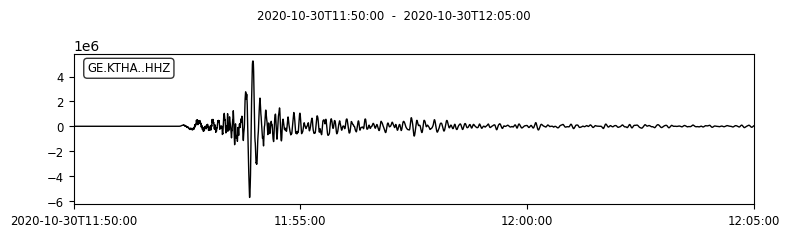

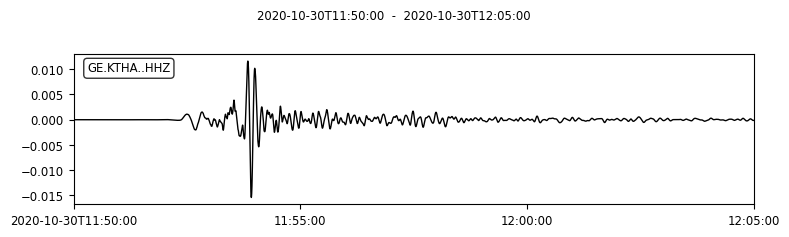

In [17]:
from obspy import UTCDateTime

starttime = UTCDateTime('2020-10-30T11:50:00')
endtime = UTCDateTime('2020-10-30T12:05:00')

st[0].plot(starttime=starttime, endtime=endtime, title='Raw');
tr.plot(starttime=starttime, endtime=endtime, title='Displacement');

## Summary <a class="anchor" id="sum"></a>

Here we have covered simple techniques to 
* **load** StationXML into an Obspy inventory,
* inventory visualization techniques of station locations and responses (**plot**),
* simple manipulation steps to add a new station (**Station** and **Channel**),
* writing of inventories into a file (**write**),
* removal of the instrumental response from raw waveforms.